# Use Case - Analytics in ITSM 

## Machine Learning Model to Predict Incident Categories based on the description and integrate model into Servicenow to automate process  to predict new incident categories

# 1. Import Libraries and load dataset

In [929]:
%matplotlib inline
import numpy as np  
import pandas as pd  
import seaborn as sns
sns.set(color_codes=True)
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [930]:
# Load the Incident dataset
data = pd.read_excel('Incidents.xlsx')

In [931]:
data.shape # Rows and Columns are matching

(7738, 5)

# 2. Data Cleaning and Exploration

In [932]:
data.dtypes

Incident Number      object
Short description    object
Priority             object
State                object
Category             object
dtype: object

#### Plot missing values (if any)

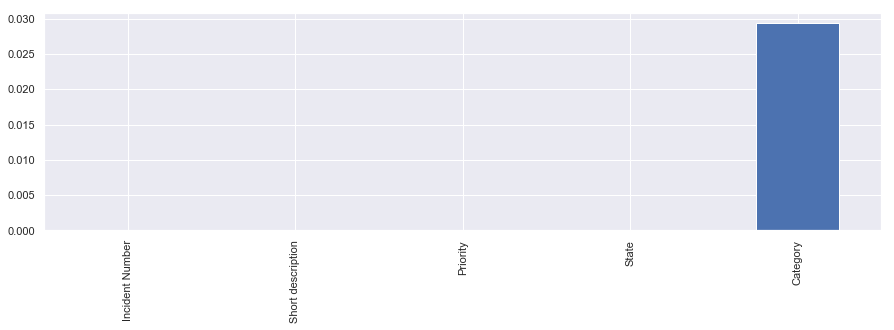

In [933]:
col_null = data.isnull().sum()
col_null_frac = col_null / data.shape[0]

plt.figure(figsize= (15,4))
col_null_frac.plot(kind='bar')

In [934]:
data.isnull().sum().sort_values(ascending=False).head()

Category             227
State                  0
Priority               0
Short description      0
Incident Number        0
dtype: int64

In [935]:
data.shape

(7738, 5)

In [936]:
data = data.replace({'Null':np.nan}).dropna()
data.shape

(7511, 5)

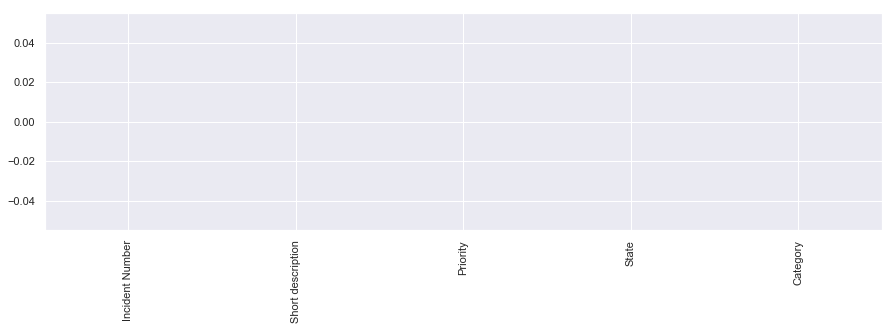

In [937]:
col_null = data.isnull().sum()
col_null_frac = col_null / data.shape[0]

plt.figure(figsize= (15,4))
col_null_frac.plot(kind='bar')

#### Check for duplicates based on the feature "cid" 

In [938]:
print(any(data['Incident Number'].duplicated()))  

False


## Plot incidents raised by priority

In [939]:
priority_critical_count   = data['Priority'][data['Priority']=="Critical (P1)"].count()
priority_important_count  = data['Priority'][data['Priority']=="Important (P3)"].count()
priority_standard_count   = data['Priority'][data['Priority']=="Standard (P4)"].count()
priority_urgent_count     = data['Priority'][data['Priority']=="Urgent (P2)"].count()
total_incidents           = [priority_critical_count,priority_important_count,priority_standard_count,priority_urgent_count]

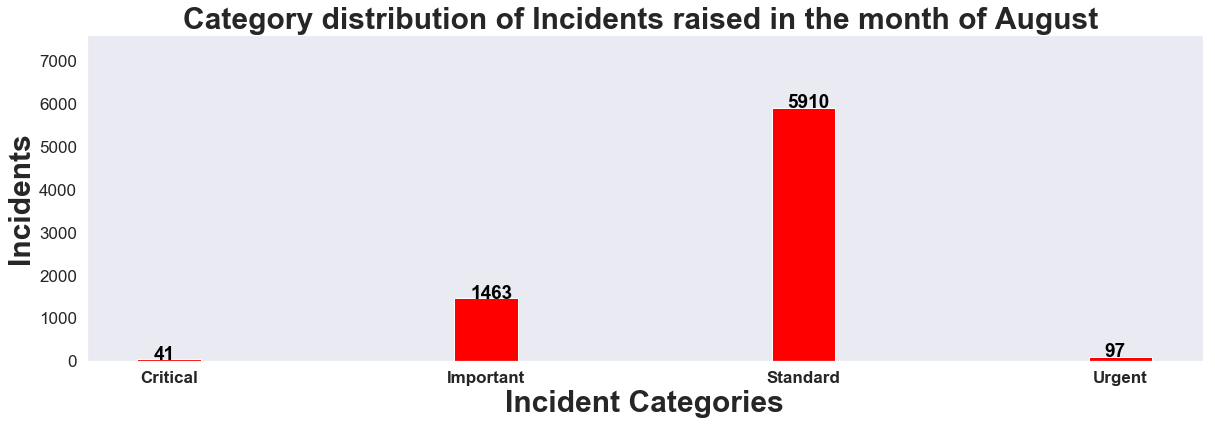

In [940]:
Category    = [1,2,3,4]
width = 0.5
plt.figure(figsize=(20,6))
width = 0.2
plt.bar(Category, total_incidents,width,color='Red' )

plt.xlabel('Incident Categories', fontsize = 30, weight = 'bold')
plt.ylabel("Incidents", fontsize = 30, weight = 'bold')
plt.title("Category distribution of Incidents raised in the month of August ",fontsize=30, weight = 'bold')

plt.xticks(fontsize=17,weight = 'bold')
plt.yticks(fontsize=17)
plt.ylim(0,7600,50)
plt.xticks(Category, ['Critical','Important','Standard','Urgent'])
plt.grid(False)

for i in range(4):
    plt.text(x = Category[i]-.05 , y = total_incidents[i],s = total_incidents[i], color = 'Black',size = 19,weight = 'bold')
plt.grid(False)

In [941]:
Active_count               = data['State'][data['State']=="Active"].count()
Awating_Evidence_count     = data['State'][data['State']=="Awaiting Evidence"].count()
Awating_External_count     = data['State'][data['State']=="Awaiting External"].count()
Awating_Problem_count      = data['State'][data['State']=="Awaiting Problem"].count()
Awating_Userinfo_count     = data['State'][data['State']=="Awaiting User Info"].count()
Closed_count               = data['State'][data['State']=="Closed"].count()
Resolved_count             =  data['State'][data['State']=="Resolved"].count()
incidents_Status           = [Active_count,Awating_Evidence_count,Awating_External_count,Awating_Problem_count,Awating_Userinfo_count,Closed_count,Resolved_count]

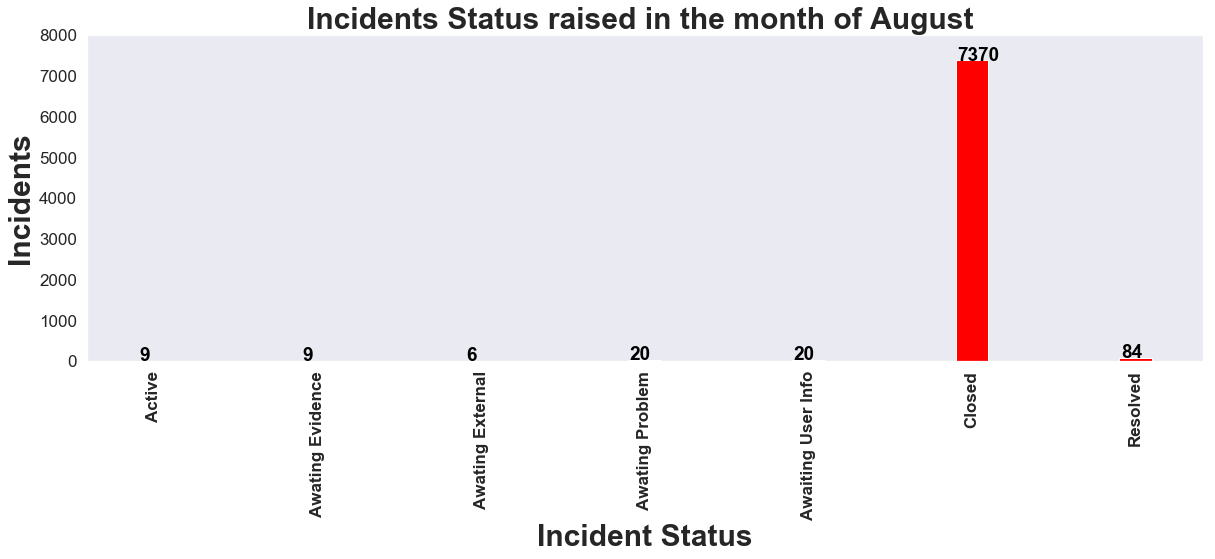

In [942]:
Category    = [1,2,3,4,5,6,7]
width = 0.5
plt.figure(figsize=(20,6))
width = 0.2
plt.bar(Category, incidents_Status,width,color='Red' )

plt.xlabel('Incident Status', fontsize = 30, weight = 'bold')
plt.ylabel("Incidents", fontsize = 30, weight = 'bold')
plt.title("Incidents Status raised in the month of August ",fontsize=30, weight = 'bold')

plt.xticks(fontsize=17,weight = 'bold')
plt.yticks(fontsize=17)
plt.ylim(0,8000)
plt.xticks(Category, ['Active','Awating Evidence','Awating External','Awating Problem','Awaiting User Info','Closed','Resolved'],rotation=90)
plt.grid(False)

for i in range(7):
    plt.text(x = Category[i]-0.09, y = incidents_Status[i]+4,s = incidents_Status[i]+1, color = 'Black',size = 19,weight = 'bold')
plt.grid(False)

# Description Classification

In [943]:
# Load the Incident dataset
#del(data)
inci_data = pd.read_excel('INCIDENT.xlsx')
inci_data.head()

,Short description,Priority,State,Category
0,Unable to access team file share,3 - Moderate,New,Inquiry
1,Performance problems with email,5 - Planning,New,Inquiry
2,Performance problems with wifi,5 - Planning,New,Inquiry
3,SAP Sales app is not accessible,1 - Critical,In Progress,Software
4,SAP Materials Management is slow or there is a...,1 - Critical,On Hold,Software


In [944]:
inci_data['Category'].value_counts()

Inquiry     12
Software    10
Network      4
Hardware     4
Database     1
Name: Category, dtype: int64

In [945]:
database = inci_data['Category'] == 'Database'
add_few = inci_data[database]
inci_data = inci_data.append([add_few]*24,ignore_index = True)

In [946]:
hardware = inci_data['Category'] == 'Hardware'
add_few = inci_data[hardware]
inci_data = inci_data.append([add_few]*5,ignore_index = True)

In [947]:
inquiry = inci_data['Category'] == 'Inquiry'
add_few = inci_data[inquiry]
inci_data = inci_data.append([add_few]*1,ignore_index = True)

In [948]:
software = inci_data['Category'] == 'Software'
add_few = inci_data[software]
inci_data = inci_data.append([add_few]*2,ignore_index = True)

In [949]:
network = inci_data['Category'] == 'Network'
add_few = inci_data[network]
inci_data = inci_data.append([add_few]*5,ignore_index = True)

In [950]:
inci_data['Category'].value_counts()

Software    30
Database    25
Network     24
Hardware    24
Inquiry     24
Name: Category, dtype: int64

In [951]:
inci_data.shape

(127, 4)

##### Split the data into training and test set in the ratio of 70:25 (Training:Test)

In [952]:
data,label = inci_data[inci_data.columns[0]],inci_data[inci_data.columns[3]]
train_data, test_data, train_label, test_label = train_test_split(data, label, test_size=0.25, random_state=123)
test_data.shape

(32,)

In [953]:
test_data.to_csv("test_data.csv")

### Text Classification steps - Convert text document to matrix of token documents

In [954]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
train_data_convert = count_vect.fit_transform(train_data)
test_data_convert = count_vect.fit_transform(test_data)
train_data_convert.shape

(95, 121)

### Get the weights of text using TfidfTransformer

In [955]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_Transformer = TfidfTransformer()
train_data_tfidf = tfidf_Transformer.fit_transform(train_data_convert)
test_data_tfidf = tfidf_Transformer.fit_transform(test_data_convert)

In [956]:
test_data_tfidf.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.40534194, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.28280174, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.28280174, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

# Choose Classifier

## MultiNomial Naive bayes 

In [958]:
from sklearn.pipeline import Pipeline
clf = Pipeline([('vect',CountVectorizer()),('tfidf',TfidfTransformer()),('clf',MultinomialNB()),])
clf = text_clf.fit(train_data,train_label)

In [959]:
Pred = clf.predict(test_data)
clf.score(test_data,test_label)

0.96875

In [917]:
Pred

array(['Software', 'Network', 'Software', 'Inquiry', 'Database',
       'Database', 'Network', 'Network', 'Software', 'Database',
       'Network', 'Hardware', 'Inquiry', 'Hardware', 'Software',
       'Inquiry', 'Software', 'Network', 'Hardware', 'Hardware',
       'Software', 'Software', 'Database', 'Database', 'Network',
       'Network', 'Software', 'Database', 'Network', 'Inquiry', 'Network',
       'Network'], dtype='<U8')

### Linear Regression

In [965]:
from sklearn.pipeline import Pipeline
lr = Pipeline([('vect',CountVectorizer()),('tfidf',TfidfTransformer()),('lr',LogisticRegression()),])
lr = lr.fit(train_data,train_label)

In [967]:
lrPred = lr.predict(test_data)
lr.score(test_data,test_label)


0.96875

### Predicted with accuracy of 97%

### Both classifiers giving same accuracy. Save the model to make new predictions on the unseen data

In [1037]:
from sklearn.externals import joblib
filename = 'PredictIncidentCategories.sav'
filename = 'PredictIncidentCategories.pkl'
joblib.dump(clf, filename)

['PredictIncidentCategories.pkl']

## Prepare data readiness to make new predictions by retrieving saved model 

In [1028]:
# Load the New Dataset
new_data = pd.read_excel('New_Incident_Dataset.xlsx')

In [1029]:
new_data.shape

(11, 3)

In [1030]:
new_data.head(11)

,Short description,Priority,State
0,problem in Sales Tools performance,4 - Low,On Hold
1,email not working,3 - Moderate,In Progress
2,Can we configure UI?,1 - Critical,In Progress
3,I can't get my weather report,5 - Planning,In Progress
4,Remove hard disk from my laptop,2 - High,In Progress
5,Need more memory to my pc,1 - Critical,In Progress
6,Server not working,1 - Critical,In Progress
7,Wireless access is down,1 - Critical,In Progress
8,Network file shares access issue,1 - Critical,On Hold
9,Laptop not working,1 - Critical,On Hold


## Data readiness to make new predictions

In [1031]:
data = new_data[new_data.columns[0]]

In [1032]:
count_vect = CountVectorizer()
new_data_convert = count_vect.fit_transform(data)
new_data_convert.shape

(11, 35)

In [1033]:
tfidf_Transformer = TfidfTransformer()
new_data_tfidf    = tfidf_Transformer.fit_transform(new_data_convert)
new_data_tfidf    = tfidf_Transformer.fit_transform(new_data_convert)

## End of Data readiness to make new predictions

# Load the model from the drive

In [1034]:
filename = 'PredictIncidentCategories.sav'
loaded_model = joblib.load(filename)

In [1035]:
Predicted_Incident_Categories = loaded_model.predict(data)
df = pd.DataFrame({'Short Description' : data, 'Predicted Category' : Predicted_Incident_Categories, 'Priority' : new_data['Priority'], 'State' : new_data['State']})
df.head(11)

,Short Description,Predicted Category,Priority,State
0,problem in Sales Tools performance,Software,4 - Low,On Hold
1,email not working,Inquiry,3 - Moderate,In Progress
2,Can we configure UI?,Inquiry,1 - Critical,In Progress
3,I can't get my weather report,Inquiry,5 - Planning,In Progress
4,Remove hard disk from my laptop,Software,2 - High,In Progress
5,Need more memory to my pc,Hardware,1 - Critical,In Progress
6,Server not working,Hardware,1 - Critical,In Progress
7,Wireless access is down,Network,1 - Critical,In Progress
8,Network file shares access issue,Network,1 - Critical,On Hold
9,Laptop not working,Hardware,1 - Critical,On Hold


In [1036]:
df.to_csv('Predicted_Categories.csv')

# End of Program¶

## NEXT STEPS

### This is one of possible analytics use-case in ITSM which will help organizations to standardize the process of identfying incident category so that incient can be assigned to the right group for actioning thereby reducing the operational notice and increasing user satisfication
